# Example SpecTf Usage

This Jupyter Notebook will serve as an example of how to use the `spectf` python package

## Organization of the Codebase

The core functionality of SpecTf resides in the `spectf/` directory, which contains the following key modules:

- **`model.py`** – Defines the SpecTf model architecture.
- **`dataset.py`** – Handles data loading and preprocessing.
- **`toa.py`** – Implements time-of-arrival computations.
- **`utils.py`** – Provides utility functions for various operations.

The `spectf_cloud/` directory primarily serves as the command-line interface (CLI) for training, evaluating, deploying, and comparing SpecTf Cloud models. Since it is not intended to be an importable package, we will not cover it here.

---

## What This Notebook Covers

This notebook focuses on understanding how to create and use a SpecTf model. Specifically, we will cover:

1. **Creating a SpecTf model**
   - Initializing and configuring a SpecTf classifier.
   - Training a classifier model.

2. **Importing a trained classifier model**
   - Loading an existing classifier model for inference.

### Note:
This example is designed to demonstrate how the SpecTf model code functions. It does **not** reproduce the exact models used in published research.

## SpecTf Model

### 1. Creating and Training a SpecTf Classifier

**First, let's create some dummy data**

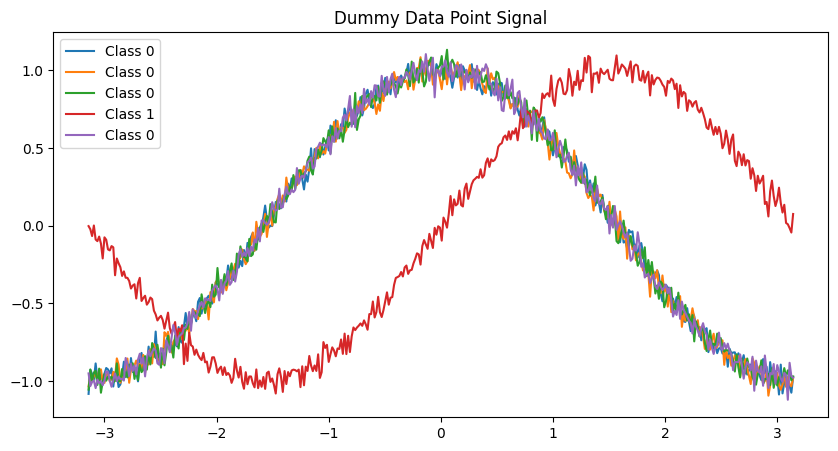

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

num_classes = 2
num_samples = 1000
num_features = 400

# Let's make the data over a full period
x_values = torch.linspace(-np.pi, np.pi, num_features)
cos_data = torch.cos(x_values).repeat(num_samples // 2, 1)
sin_data = torch.sin(x_values).repeat(num_samples // 2, 1)
# Add in Gaussian noise
noise_std = 0.05
cos_data += torch.randn_like(cos_data) * noise_std
sin_data += torch.randn_like(sin_data) * noise_std

dummy_data = torch.cat([cos_data, sin_data], dim=0)
dummy_labels = torch.cat([torch.zeros(num_samples // 2, dtype=torch.long),
                          torch.ones(num_samples // 2, dtype=torch.long)])

# Shuffle the data
indices = torch.randperm(num_samples)
dummy_data = dummy_data[indices]
dummy_labels = dummy_labels[indices]

# DDummy wavelength nanometer values
dummy_band_indices = torch.arange(start=100, end=100 + num_features)

# Plot a few examples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(x_values.numpy(), dummy_data[i].numpy(), label=f"Class {dummy_labels[i].item()}")
plt.legend()
plt.title("Dummy Data Point Signal")
plt.show()

**Then, let's build a SpecTf model**

In [4]:
from spectf import model
from spectf.dataset import SpectraDataset

In [5]:
model.SpecTfEncoder?

Init signature:
model.SpecTfEncoder(
    banddef: torch.Tensor,
    dim_output: int = 2,
    num_heads: int = 8,
    dim_proj: int = 64,
    dim_ff: int = 64,
    dropout: float = 0.1,
    agg: str = 'max',
    use_residual: bool = False,
    num_layers: int = 1,
)
Docstring:     
Encoder based Spectral Transformer model.

This is the simplest Spectral Transformer architecture, consisting only of
encoder layers. For most tasks, a single encoder layer is a good starting
point. Aside from hyperparameters that affect the dimensionality of layers,
the aggregation method is the most significant parameter to tune. Some
intuition suggests that 'max' aggregation is appropriate for tasks where
a few bands are more important than others, while 'mean' aggregation is
appropriate when the overall shape of the spectrum is important. While the
'flat' aggregation avoids pooling altogether, it fixes the length of the
input sequence, and limits the model to a fixed set of bands.

Model weights are initi

In [144]:
our_spectf_model = model.SpecTfEncoder(
    banddef    = dummy_band_indices,
    dim_output = num_classes,
    num_heads  = 1,
    dim_proj   = 5,
    dim_ff     = 20,
    dropout    = 0.1,
    agg        = 'flat',
).to(device)

**Model is all built now!**

In [145]:
our_spectf_model

SpecTfEncoder(
  (band_concat): BandConcat()
  (spectral_embed): SpectralEmbed(
    (linear): Linear(in_features=2, out_features=5, bias=True)
    (activation): Tanh()
  )
  (layers): ModuleList(
    (0): EncoderLayer(
      (attention): AttentionBlock(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForwardBlock(
        (linear1): Linear(in_features=5, out_features=20, bias=True)
        (linear2): Linear(in_features=20, out_features=5, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (gelu): GELU(approximate='none')
      )
      (norm1): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
    )
  )
  (head): Linear(in_features=2000, out_features=2, bias=True)
)

In [146]:
print('Total number of parameters:', sum(p.numel() for p in our_spectf_model.parameters() if p.requires_grad))

Total number of parameters: 4382


**Next, let's train it**

Because of 2 classes, and using cross-entropy loss (H(P) + D_KL(P||Q)), we expect the initial loss to be 
$$
\mathcal{L} = -\sum_{i=1}^{2} p_i \log q_i
$$
`p_i` is the one-hot answer.
Where, with a uniform prior, 
$$
q_i = \frac{1}{C} = \frac{1}{2}
$$
Thus, the initial loss is expected to be about
$$
\mathcal{L} = -\log \frac{1}{2} = 0.69314718056
$$
**NOTE: The variance in the logits (due to model init/class balance) will likely make this estimate off by a non-negliable margin**

In [147]:
bsz = 5
epochs = 1
lr = 3e-4
warmup_steps = 1000
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW((p for p in our_spectf_model.parameters() if p.requires_grad), lr=lr, betas=(0.9, 0.98))

train_dataset = SpectraDataset(dummy_data, dummy_labels, transform=None, device=device)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bsz, shuffle=True)

our_spectf_model.train()

losses = []
for epoch in range(epochs):
    for batch_ in train_dataloader:
        spectra = batch_['spectra'].float()
        labels = batch_['label']

        optimizer.zero_grad()
        pred = our_spectf_model(spectra)
        loss = criterion(pred, labels)
        losses.append(loss.item())
        loss.backward()

        # Gradient clipping to prevent exploding gradients - (not useful for our example but good in practice)
        torch.nn.utils.clip_grad_norm_(our_spectf_model.parameters(), 1.0)

        optimizer.step()

/var/folders/5r/tq98z9mx7ldcmk7cpdx25hvh0000gq/T/ipykernel_91918/401018185.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = our_spectf_model(torch.tensor(dummy_data).unsqueeze(-1))


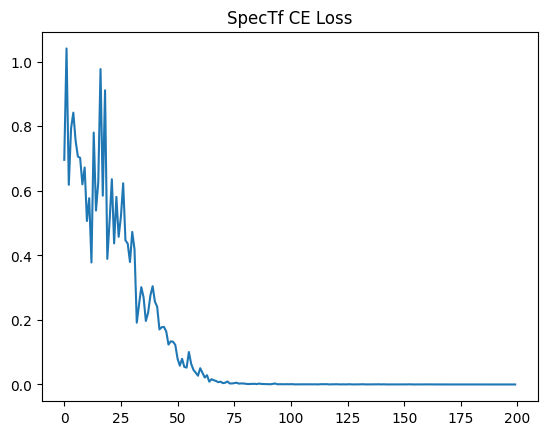

In [172]:
plt.title("SpecTf CE Loss")
plt.plot(losses);

/var/folders/5r/tq98z9mx7ldcmk7cpdx25hvh0000gq/T/ipykernel_91918/877412237.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_1_data = torch.tensor(dummy_data[dummy_labels==1]).unsqueeze(-1)


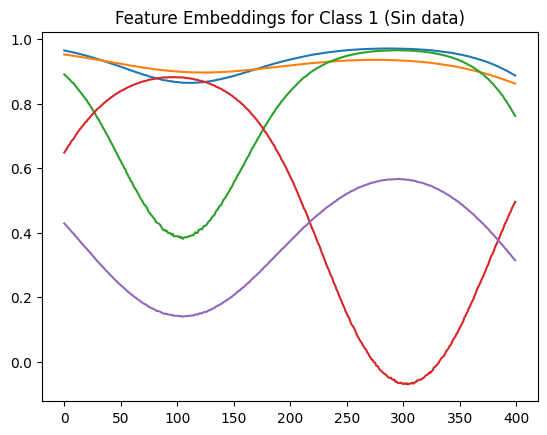

In [169]:
with torch.no_grad():
    class_1_data = torch.tensor(dummy_data[dummy_labels==1]).unsqueeze(-1)
    x = our_spectf_model.band_concat(class_1_data)
    embeddings = our_spectf_model.spectral_embed(x)
    plt.title('Feature Embeddings for Class 1 (Sin data)')
    plt.plot(embeddings.mean(0));

/var/folders/5r/tq98z9mx7ldcmk7cpdx25hvh0000gq/T/ipykernel_91918/1139509541.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_0_data = torch.tensor(dummy_data[dummy_labels==0]).unsqueeze(-1)


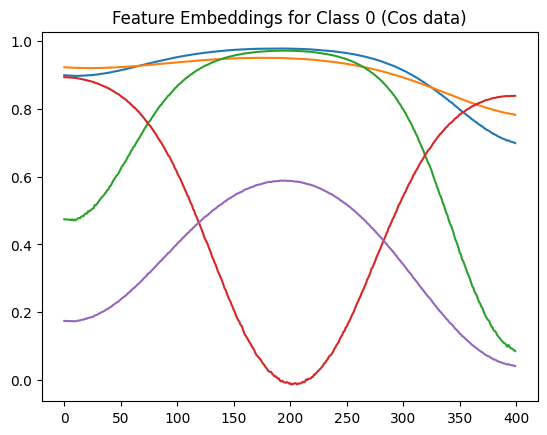

In [171]:
with torch.no_grad():
    class_0_data = torch.tensor(dummy_data[dummy_labels==0]).unsqueeze(-1)
    x = our_spectf_model.band_concat(class_0_data)
    embeddings = our_spectf_model.spectral_embed(x)
    plt.title('Feature Embeddings for Class 0 (Cos data)')
    plt.plot(embeddings.mean(0));

SWEET! We just trained a SpecTf classifier! :) 

### 2. Importing a Trained Classifier Model

We will be using the same dummy data and labels as in example 1

In [6]:
from spectf import model
import requests
import io
import yaml

In [7]:
num_classes = 2

In [14]:
# let's download the architecture file and create a model from it
device = torch.device("cpu")

yaml_url = "https://github.com/emit-sds/SpecTf/blob/main/spectf_cloud/spectf_cloud_config.yml?raw=true"

response = requests.get(yaml_url)
response.raise_for_status()

yaml_content = yaml.safe_load(response.text)
architecture = yaml_content['architecture']
architecture

{'dim_proj': 64, 'num_heads': 8, 'dim_ff': 64, 'agg': 'max'}

In [15]:
our_spectf_model = model.SpecTfEncoder(
    banddef    = dummy_band_indices,
    dim_output = num_classes,
    **architecture
).to(device)

In [16]:
print('Total number of parameters:', sum(p.numel() for p in our_spectf_model.parameters() if p.requires_grad))

Total number of parameters: 25538


In [189]:
# load in the weights
weights_url = "https://github.com/emit-sds/SpecTf/blob/main/spectf_cloud/weights/current.pt?raw=true"

response = requests.get(weights_url)
response.raise_for_status()

weights_buffer = io.BytesIO(response.content)
state_dict = torch.load(weights_buffer, map_location=device, weights_only=True)

our_spectf_model.load_state_dict(state_dict)

our_spectf_model.eval()

SpecTfEncoder(
  (band_concat): BandConcat()
  (spectral_embed): SpectralEmbed(
    (linear): Linear(in_features=2, out_features=64, bias=True)
    (activation): Tanh()
  )
  (layers): ModuleList(
    (0): EncoderLayer(
      (attention): AttentionBlock(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForwardBlock(
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (gelu): GELU(approximate='none')
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (head): Linear(in_features=64, out_features=2, bias=True)
)

In [191]:
# Now let's see how it does on the dummy data - should be about random guessing
correct_class_0 = 0
total_class_0 = 0
correct_class_1 = 0
total_class_1 = 0

with torch.no_grad():
    for batch_ in train_dataloader:
        spectra = batch_['spectra'].float()
        labels = batch_['label']

        pred_logits = our_spectf_model(spectra)
        pred_labels = torch.argmax(pred_logits, dim=1)

        # Count correct predictions for each class
        for true_label, predicted_label in zip(labels, pred_labels):
            if true_label == 0:
                total_class_0 += 1
                if predicted_label == 0:
                    correct_class_0 += 1
            elif true_label == 1:
                total_class_1 += 1
                if predicted_label == 1:
                    correct_class_1 += 1

accuracy_class_0 = (correct_class_0 / total_class_0) * 100 if total_class_0 > 0 else 0
accuracy_class_1 = (correct_class_1 / total_class_1) * 100 if total_class_1 > 0 else 0

print(f"Class 0 Accuracy: {accuracy_class_0:.2f}% ({correct_class_0}/{total_class_0})")
print(f"Class 1 Accuracy: {accuracy_class_1:.2f}% ({correct_class_1}/{total_class_1})")

Class 0 Accuracy: 0.00% (0/500)
Class 1 Accuracy: 100.00% (500/500)


Should be about 50% accuracy in total with balanced classes since the imported model was trained on a very different distribution

AWESOME! We now just loaded a model that we can use to classify spectra